# 20211012-zhan-statistics
Evaluate IPCs, accuracy, and coverage over simpoints for the base prefetchers, for *Zhan's traces*.

In [10]:
import os
import sys
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import attrdict
import matplotlib.pyplot as plt

from utils.load import load_simpoint_weights, parse_champsim_result_file, load_champsim_base_results, parse_paper_result_file

---
# User parameters.

You can look at the simpoint-weights or the data to get the trace_id for the trace you want.

In [11]:
simpoints_dir = 'data/simpoint-weights/'
results_dir = 'data/zhan-prefetch1-fixedcache-250m/'
max_instruction_num = 250   # in millions
min_instruction_interval = 0 # in millions (this does not affect IPC results much)
verbose = True

---
# Load and preprocess results.
- `ml_prefetch_sim.py eval --results-dir <>`

In [12]:
stats = pd.read_csv(results_dir + 'stats.csv')
stats.Trace = stats.Trace.map(lambda t: t.split('.')[0].split('_')[0])
stats

,Trace,Baseline,Accuracy,Coverage,UAC,MPKI,MPKI_Improvement,IPC,IPC_Improvement
0,bfs,no,NaN,NaN,NaN,10.649808,NaN,0.400746,NaN
1,bfs,bo,68.240373,58.313389,23.298645,4.439544,58.428371,0.531870,32.719977
2,bfs,sisb,89.280508,66.323900,53.909231,3.586440,66.416787,0.562613,40.391420
3,bfs,sisb_bo,88.699359,67.024344,53.245199,3.511844,67.115299,0.565536,41.120810
4,mcf,no,NaN,NaN,NaN,70.754244,NaN,0.098313,NaN
5,mcf,bo,70.779977,0.006196,0.000000,70.749860,0.180699,0.098320,0.007832
6,mcf,sisb,77.068077,39.514899,39.506586,42.795776,39.620454,0.138215,40.587270
7,mcf,sisb_bo,77.100043,39.595589,39.470659,42.738684,39.701004,0.138261,40.634059
8,astar,no,NaN,NaN,NaN,43.239336,NaN,0.115519,NaN
9,astar,bo,69.320599,5.150625,0.489469,41.012240,5.198956,0.116933,1.224041


---
# Plotting / table helpers

**TODO** Break out into a utils file

In [13]:
def plot_results(df, column, y_label, subtitle=None, paper_data=None, factor = 1., ymin=None, ymax=None, legend=True, plot_baseline=False):
    """Plot data for a
    list of prefetchers and traces.
    """
    traces = sorted(set(df.Trace))
    fig, ax = plt.subplots(dpi=128)
    #ax.grid()
    #ax.set_axisbelow(True) # Plot grid under bars.
    
    sep = 1
    if paper_data:
        step_size = 0.2 #0.1
        width = 0.15 #0.075
    else:
        step_size = 0.2
        width = 0.15
        
    for i, tr in enumerate(traces):
        tr_data = df[df.Trace == tr]
        nsteps = 0 # Tracks where to place each bar
        
        ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column], 
               color='C0', width = width, 
               label='BO' if i == 0 else ''
        )
        nsteps += 1
        
#         ax.bar(i + nsteps*step_size, tr_data[df.Baseline == 'sisb'][column], 
#                color='C1', width=width, 
#                label='ISB' if i == 0 else ''
#         )
#         nsteps += 1
            
#         ax.bar(i + nsteps*step_size, tr_data[df.Baseline == 'sisb_bo'][column], 
#                color='C2', width=width, 
#                label='ISB + BO' if i == 0 else ''
#         )
#         nsteps += 1
        
        if paper_data and tr in paper_data:
            ax.bar(i*sep + nsteps*step_size, paper_data[tr]['Paper-BO'] * factor, 
                   color='C0', edgecolor='C0', alpha=0.25, width=width, 
                   label='Paper BO' if i == 0 else ''
            )
            nsteps += 1
                
            ax.bar(i*sep + nsteps*step_size, paper_data[tr]['Paper-ISB'] * factor, 
                   color='C1', edgecolor='C1', alpha=0.25, width=width, 
                   label='Paper ISB' if i == 0 else ''
            )
            nsteps += 1
                
            ax.bar(i*sep + nsteps*step_size, paper_data[tr]['Paper-Voyager'] * factor, 
                   color='C3', edgecolor='C3', alpha=0.25, width=width, 
                   label='Paper Voyager' if i == 0 else ''
            )
            nsteps += 1
                
        if plot_baseline:
            ax.bar(i*sep + nsteps*step_size, tr_data[df.Baseline == 'no'][column] * factor, 
                   color='gray', edgecolor='gray', alpha=0.25, width=width, 
                   label='No prefetcher' if i == 0 else ''
            )
            nsteps += 1
            
    if legend:
        ax.legend()
    ax.set_xticks(np.arange(0, len(traces)) + (nsteps*width/2))
    ax.set_xticklabels(traces, fontdict={'size': 7})
    if subtitle:
        title += f' ({subtitle})'
    ax.set_title(column)
    ax.set_ylabel(y_label)
    ax.set_ylim(ymin=ymin, ymax=ymax)

/tmp/ipykernel_29413/3258471008.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column],
/tmp/ipykernel_29413/3258471008.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep + nsteps*step_size, tr_data[df.Baseline == 'no'][column] * factor,


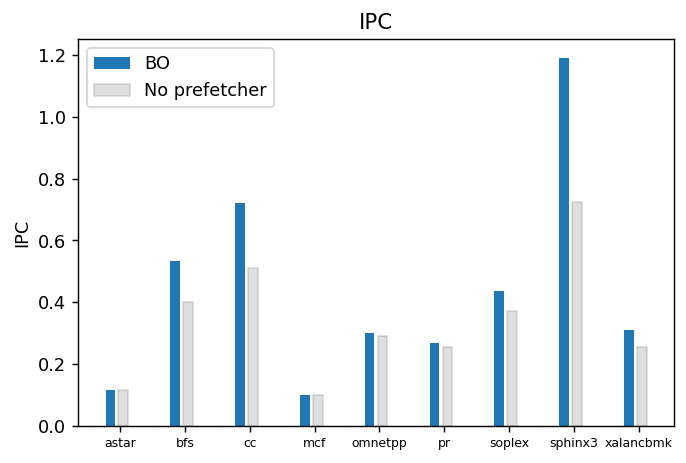

In [14]:
plot_results(
    stats, 'IPC', 'IPC',
    ymin=0,
    plot_baseline=True,
)

#### IPC speedup (vs. no prefetcher)

/tmp/ipykernel_29413/3258471008.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column],


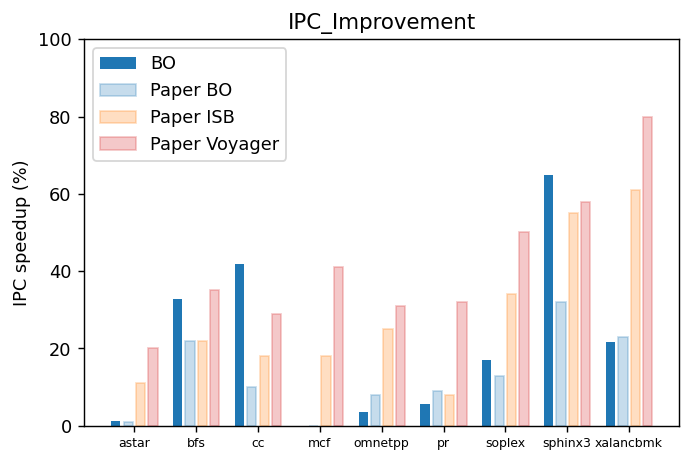

In [15]:
paper_ipc_speedups = parse_paper_result_file('data/paper-values/paper_ipc_speedups.csv', strip_prefixes=True)

plot_results(
    stats, 'IPC_Improvement', 'IPC speedup (%)', 
    factor=100,
    ymin=0, ymax=100,
    paper_data=paper_ipc_speedups
)

---
# Accuracy measurements
Accuracy = useful / (useful + useless) prefetches
- WAM: Take the weighted arithmatic mean of accuracies for the given trace, using the simpoint weights.
- Largest simpoint: Only consider accuracy of the largest (highest-weighted) simpoint.

/tmp/ipykernel_29413/3258471008.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column],


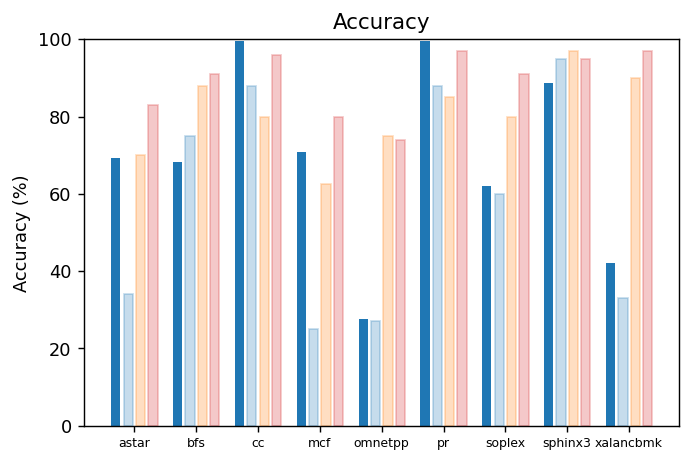

In [16]:
paper_accs = parse_paper_result_file('data/paper-values/paper_accuracies.csv', strip_prefixes=True)

plot_results(
    stats, 'Accuracy', 'Accuracy (%)', 
    factor=100,
    ymin=0, ymax=100,
    paper_data=paper_accs,
    legend=False
)

---
# Coverage measurements
Coverage = Percent decrease of:
- \# of LLC load + RFO misses on a prefetcher
- vs. # of LLC load + RFO misses on baseline (NoPrefetcher)
- WAM: Take the weighted arithmatic mean of coverages for the given trace, using the simpoint weights.
- Largest simpoint: Only consider coveraeg of the largest (highest-weighted) simpoint.

/tmp/ipykernel_29413/3258471008.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column],


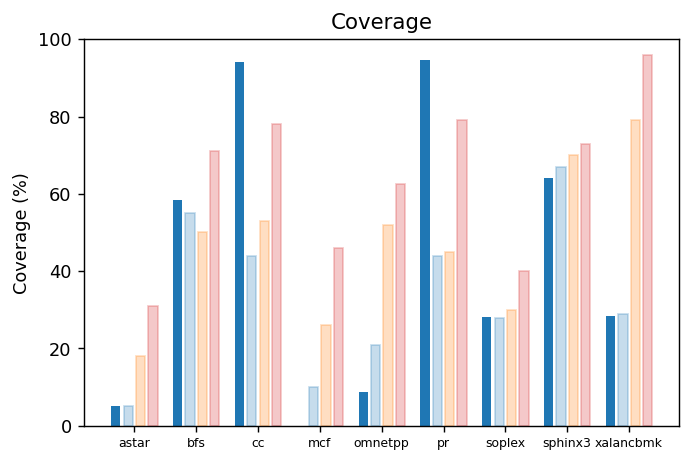

In [17]:
paper_covs = parse_paper_result_file('data/paper-values/paper_coverages.csv', strip_prefixes=True)
paper_covs

plot_results(
    stats, 'Coverage', 'Coverage (%)',
    factor=100.,
    ymin=0, ymax=100,
    paper_data=paper_covs,
    legend=False
)

---
# Unified accuracy/coverage

/tmp/ipykernel_29413/3258471008.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column],


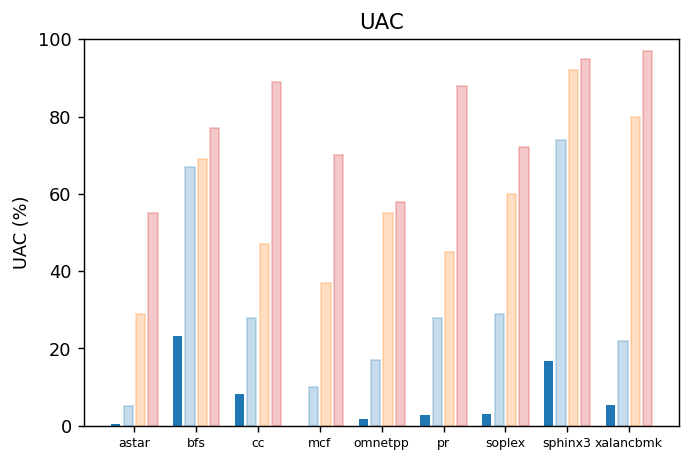

In [18]:
paper_uacs = parse_paper_result_file('data/paper-values/paper_uacs.csv', strip_prefixes=True)

plot_results(
    stats, 'UAC', 'UAC (%)',
    factor=100.,
    ymin=0, ymax=100,
    paper_data=paper_uacs,
    legend=False
)